In [1]:
import os
import tarfile
from six.moves import urllib

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/"
HOUSING_PATH = os.path.join("datasets","housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()
    

In [2]:
fetch_housing_data()

URLError: <urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1056)>

In [3]:
import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)



In [4]:
housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [5]:
housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

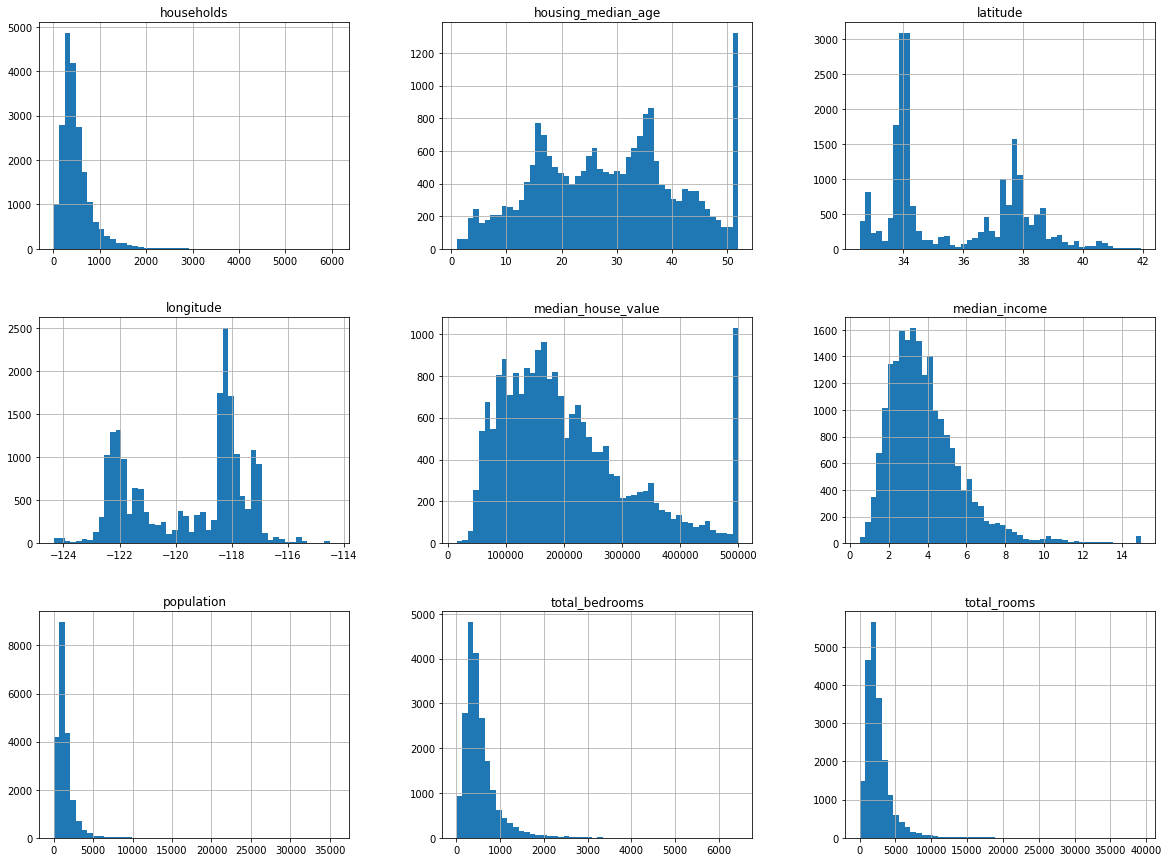

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
housing.hist(bins=50, figsize=(20,15))
plt.show()

In [7]:
import numpy as np

def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [8]:
train_set, test_set = split_train_test(housing, 0.2)

In [9]:
len(train_set)

16512

In [10]:
from zlib import crc32

def test_set_check(identifier, test_ratio):
    return crc32(np.int64(identifier)) & 0xffffffff < test_ratio * 2**32

def split_train_test_by_id(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

In [11]:
housing_with_id = housing.reset_index()
housing_with_id["id"] = housing["longitude"] * 1000 + housing["latitude"]
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "index")

In [12]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

In [13]:
housing["income_cat"] = pd.cut(housing["median_income"],bins=[0.,1.5,3.0,4.5,6.,np.inf],labels=[1,2,3,4,5])

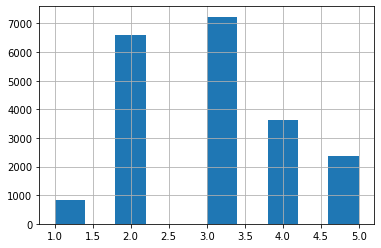

In [14]:
housing["income_cat"].hist()

In [15]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [16]:
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

3    0.350533
2    0.318798
4    0.176357
5    0.114583
1    0.039729
Name: income_cat, dtype: float64

In [17]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

In [18]:
housing = strat_train_set.copy()

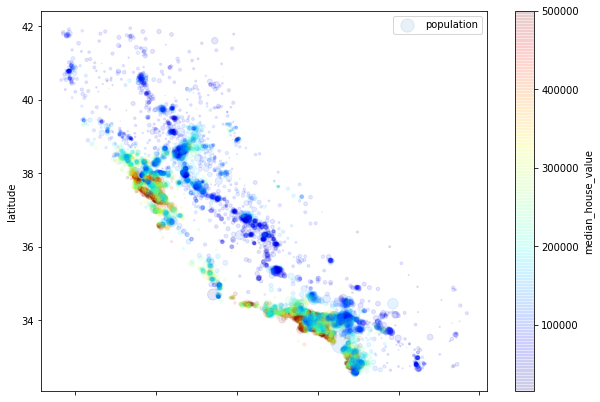

In [19]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1, s=housing["population"]/100, label="population", figsize=(10,7), c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True)
plt.legend()

In [20]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12f6556d8>,
      dtype=object)

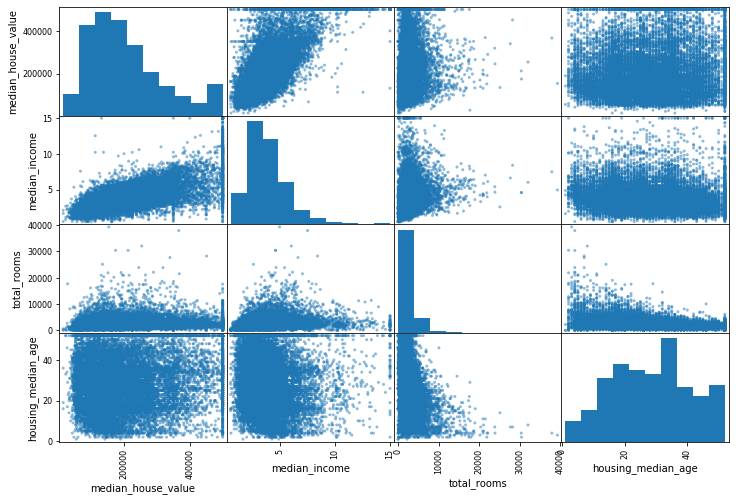

In [21]:
from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12,8))

In [22]:
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"]=housing["population"]/housing["households"]

In [23]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

In [24]:
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

In [25]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="median")

In [26]:
housing_num = housing.drop("ocean_proximity", axis=1)
imputer.fit(housing_num)

SimpleImputer(add_indicator=False, copy=True, fill_value=None,
              missing_values=nan, strategy='median', verbose=0)

In [27]:
X = imputer.transform(housing_num)

In [28]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns)

In [29]:
from sklearn.preprocessing import OrdinalEncoder
housing_cat = housing[["ocean_proximity"]]
ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
housing_cat_encoded[:10]


array([[0.],
       [0.],
       [4.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.]])

In [30]:
housing[["ocean_proximity"]]

,ocean_proximity
17606,<1H OCEAN
18632,<1H OCEAN
14650,NEAR OCEAN
3230,INLAND
3555,<1H OCEAN
...,...
6563,INLAND
12053,INLAND
13908,INLAND
11159,<1H OCEAN


In [31]:
from sklearn.preprocessing import OneHotEncoder
cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [32]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [33]:
from sklearn.base import BaseEstimator, TransformerMixin

rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6
class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    
    def __init__(self, add_bedrooms_per_room = True):
        self.add_bedrooms_per_room = add_bedrooms_per_room
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_atrribs = attr_adder.transform(housing.values)
housing_extra_atrribs

array([[-121.89, 37.29, 38.0, ..., '<1H OCEAN', 4.625368731563422,
        2.094395280235988],
       [-121.93, 37.05, 14.0, ..., '<1H OCEAN', 6.008849557522124,
        2.7079646017699117],
       [-117.2, 32.77, 31.0, ..., 'NEAR OCEAN', 4.225108225108225,
        2.0259740259740258],
       ...,
       [-116.4, 34.09, 9.0, ..., 'INLAND', 6.34640522875817,
        2.742483660130719],
       [-118.01, 33.82, 31.0, ..., '<1H OCEAN', 5.50561797752809,
        3.808988764044944],
       [-122.45, 37.77, 52.0, ..., 'NEAR BAY', 4.843505477308295,
        1.9859154929577465]], dtype=object)

In [34]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="median")), 
    ('attribs_adder', CombinedAttributesAdder()), 
    ('std_scaler', StandardScaler())
])
housing_num_tr = num_pipeline.fit_transform(housing_num)

In [35]:
from sklearn.compose import ColumnTransformer
num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", OneHotEncoder(), cat_attribs)
])

housing_prepared = full_pipeline.fit_transform(housing)

In [36]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [37]:
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)
print("Predictions:", lin_reg.predict(some_data_prepared))
print("Labels:", list(some_labels))

Predictions: [210644.60459286 317768.80697211 210956.43331178  59218.98886849
 189747.55849879]
Labels: [286600.0, 340600.0, 196900.0, 46300.0, 254500.0]


In [38]:
from sklearn.metrics import mean_squared_error
housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68628.19819848922

In [39]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)

housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

In [40]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(tree_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

In [41]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

In [42]:
display_scores(tree_rmse_scores)

Scores: [67940.51545366 66888.10029222 71342.98251749 70029.96346624
 70407.20100016 76197.35924524 71313.1830126  71392.3789995
 75824.58714554 69406.63546146]
Mean: 71074.29065940942
Standard deviation: 2840.8279091500426


In [43]:
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [66782.73843989 66960.118071   70347.95244419 74739.57052552
 68031.13388938 71193.84183426 64969.63056405 68281.61137997
 71552.91566558 67665.10082067]
Mean: 69052.46136345083
Standard deviation: 2731.674001798348


In [44]:
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor(n_estimators=10)
forest_reg.fit(housing_prepared, housing_labels)
forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
forest_rmse = np.sqrt(-forest_scores)
display_scores(forest_rmse)

Scores: [52226.37911866 50781.52569524 51583.90445011 56189.72616466
 53160.13908102 56073.93615761 51045.06383186 50639.24594728
 56283.00087893 52706.85989753]
Mean: 53068.978122289875
Standard deviation: 2176.830410099607


In [45]:
import joblib

joblib.dump(forest_reg, "forest_reg_test.pkl")

['forest_reg_test.pkl']

In [46]:
forest_reg_loaded = joblib.load("forest_reg_test.pkl")

In [47]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]}
]

forest_reg = RandomForestRegressor()
grid_search = GridSearchCV(forest_reg, param_grid, cv=5, scoring='neg_mean_squared_error', return_train_score=True)
grid_search.fit(housing_prepared, housing_labels)
grid_search.best_params_

{'max_features': 8, 'n_estimators': 30}

In [48]:
grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features=8, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=30,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [49]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

63869.36229394949 {'max_features': 2, 'n_estimators': 3}
55907.741824846176 {'max_features': 2, 'n_estimators': 10}
53047.9980429974 {'max_features': 2, 'n_estimators': 30}
59571.75218377144 {'max_features': 4, 'n_estimators': 3}
53006.39914170157 {'max_features': 4, 'n_estimators': 10}
50641.683289431654 {'max_features': 4, 'n_estimators': 30}
59282.044569702215 {'max_features': 6, 'n_estimators': 3}
52386.38912678451 {'max_features': 6, 'n_estimators': 10}
50413.42248940832 {'max_features': 6, 'n_estimators': 30}
58480.7302720274 {'max_features': 8, 'n_estimators': 3}
52463.357187963156 {'max_features': 8, 'n_estimators': 10}
50108.26597470833 {'max_features': 8, 'n_estimators': 30}
62913.348384128076 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54559.23664339276 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
60084.86238242507 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
52514.26889782814 {'bootstrap': False, 'max_features': 3, 'n_estimators':

In [50]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([7.10543990e-02, 6.24902146e-02, 4.20870358e-02, 1.61768267e-02,
       1.49725031e-02, 1.51084459e-02, 1.46951165e-02, 3.65894676e-01,
       5.37810052e-02, 1.10356339e-01, 5.91582219e-02, 1.03668329e-02,
       1.58081079e-01, 4.52713901e-05, 2.16912790e-03, 3.56290467e-03])

In [51]:
extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
cat_encoder = full_pipeline.named_transformers_["cat"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)



[(0.3658946758757868, 'median_income'),
 (0.15808107908477975, 'INLAND'),
 (0.11035633940583228, 'pop_per_hhold'),
 (0.07105439901111246, 'longitude'),
 (0.06249021463602418, 'latitude'),
 (0.05915822186534489, 'bedrooms_per_room'),
 (0.05378100522754702, 'rooms_per_hhold'),
 (0.042087035797727004, 'housing_median_age'),
 (0.0161768267020929, 'total_rooms'),
 (0.015108445866043253, 'population'),
 (0.014972503147776702, 'total_bedrooms'),
 (0.014695116521156302, 'households'),
 (0.010366832899182433, '<1H OCEAN'),
 (0.003562904674208419, 'NEAR OCEAN'),
 (0.0021691278953294493, 'NEAR BAY'),
 (4.527139005617748e-05, 'ISLAND')]

In [52]:
final_model = grid_search.best_estimator_
x_test = strat_test_set.drop(["median_house_value"], axis=1)
y_test = strat_test_set["median_house_value"].copy()
x_test_prepared = full_pipeline.transform(x_test)
final_predictions = final_model.predict(x_test_prepared)
final_mse = mean_squared_error(final_predictions, y_test)
final_rmse = np.sqrt(final_mse)
final_rmse

48086.87437754514

In [53]:
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVR
svr = SVR()
scores = cross_val_score(svr, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
svr_scores = np.sqrt(-scores)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this 

In [54]:
svr_scores

array([111393.33263237, 119546.71049753, 116961.00489445, 120449.0155974 ,
       117622.20149716, 122303.76986818, 117640.09907103, 121459.63518806,
       120348.51364519, 118025.61954959])

In [55]:
from sklearn.model_selection import RandomizedSearchCV

svr_param_grid = {'kernel': ["linear", "rbf"], 'gamma': [0.1, 0.2, 0.4, 0.7, 1], 'C': [0.1, 0.5, 1, 2, 5]}


randomized_search = RandomizedSearchCV(svr, svr_param_grid, cv=5, scoring='neg_mean_squared_error', return_train_score=True)
randomized_search.fit(housing_prepared, housing_labels)
randomized_search.best_params_

KeyboardInterrupt: 

In [ ]:
best_svr = grid_search.best_estimator_
best_svr.fit(housing_prepared, housing_labels)
x_test = strat_test_set.drop("median_house_value", axis=1)
x_test_prepared = full_pipeline.transform(x_test)
y_test = strat_test_set["median_house_value"].copy()
predictions = best_svr.predict(x_test_prepared)
mse = mean_squared_error(predictions, y_test)
rmse = np.sqrt(mse)
rmse

In [56]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="median")), 
    ('attribs_adder', CombinedAttributesAdder()), 
    ('std_scaler', StandardScaler())
])

In [57]:
from sklearn.compose import ColumnTransformer
num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

prepare_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", OneHotEncoder(), cat_attribs)
])

In [58]:
from sklearn.base import BaseEstimator, TransformerMixin

def indices_of_top_k(arr, k):
    return np.sort(np.argpartition(np.array(arr), -k)[-k:])

class TopFeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, feature_importances, k):
        self.feature_importances = feature_importances
        self.k = k
    def fit(self, X, y=None):
        self.feature_indices_ = indices_of_top_k(self.feature_importances, self.k)
        return self
    def transform(self, X):
        return X[:, self.feature_indices_]

In [72]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor

full_pipeline = Pipeline([
    ('prepare_subpipeline', prepare_pipeline),
    ('attrib_remover', TopFeatureSelector(feature_importances, 5)),
    ('std_scaler', StandardScaler()),
    ('predictor', RandomForestRegressor(n_estimators=30))
])

In [73]:
full_pipeline.fit(housing, housing_labels)

Pipeline(memory=None,
         steps=[('prepare_subpipeline',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  Pipeline(memory=None,
                                                           steps=[('imputer',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value=None,
                                                                                 missing_values=nan,
                                                                                 strategy='median',
                                                      

In [75]:
x_test_set = strat_test_set.drop("median_house_value", axis=1)
y_test_set = strat_test_set.copy()["median_house_value"]
prediction_results = full_pipeline.predict(x_test_set)
mse = mean_squared_error(prediction_results, y_test_set)
rmse = np.sqrt(mse)

In [76]:
rmse

49501.22597996903